In [6]:
import os, logging
import numpy as np
import torch as th
from Transformations import *
from BloodDataset import BloodDataset
from Data import get_datasets
from ExploratoryDataAnalysis import *
import utils, random
from TrainingTesting import hyperparameter_search, train_and_test, get_roc_metrics
from Models import *
from sklearn.metrics import RocCurveDisplay

In [2]:
np.random.seed(0)
th.manual_seed(0)
random.seed(0)

logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger('MSP_Project')
logger.setLevel(logging.DEBUG)

in_colab = False
if os.getenv("COLAB_RELEASE_TAG"):
    in_colab = True
    logger.debug("Running in Colab")
USING_MNIST = False
device = utils.get_device()

train_set, test_set = get_datasets(in_colab, USING_MNIST)

DEBUG:MSP_Project:Data directory: ./full_dataset
DEBUG:MSP_Project:Using mean and std: tensor([0.9961]), tensor([0.0113])
/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
DEBUG:MSP_Project:Class percentages: {'blunt_trauma': 0.5258620689655172, 'firearm': 0.47413793103448276}
DEBUG:MSP_Project:Trying to get a representative test set...
DEBUG:MSP_Project:Class percentages: {'blunt_trauma': 0.5217391304347826, 'firearm': 0.4782608695652174}
DEBUG:MSP_Project:93 images in training set before augmentation.
DEBUG:MSP_Project:372 images in training set.
DEBUG:MSP_Project:23 images in test set.


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

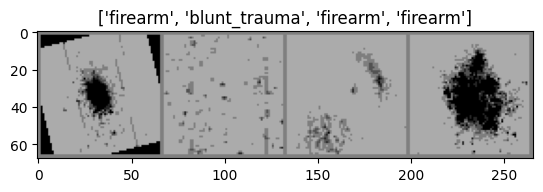

DEBUG:MSP_Project:Dataset classes:['blunt_trauma', 'firearm']
DEBUG:MSP_Project:Class Counts: {'blunt_trauma': 196, 'firearm': 176}


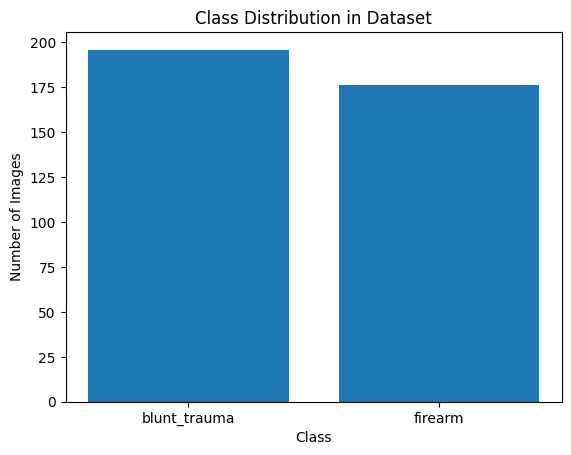

In [3]:
run_eda(train_set)

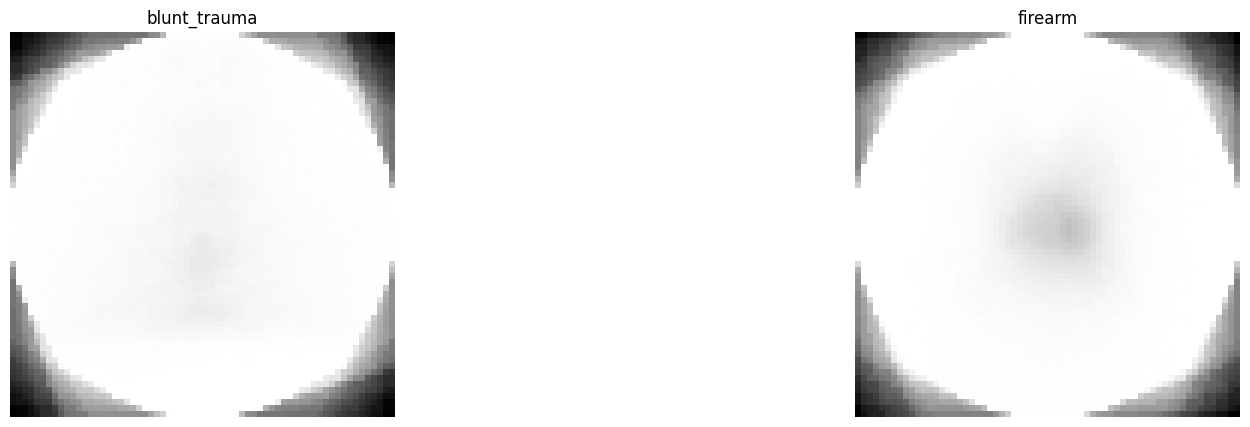

In [4]:
calculate_class_average(train_set)

FOLD 0
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 1
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 2
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 3
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting testing
FOLD 4
--------------------------------
Starting epoch 1
Starting epoch 2
Starting epoch

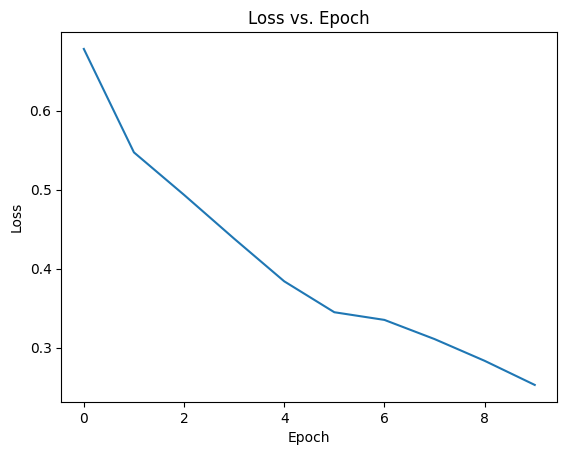

In [12]:
from TrainingTesting import k_fold_cross_validation
from Models import *
from plotting import plot_loss

model = SpikingCNN(beta=0.8, num_steps=10, using_mnist=USING_MNIST)
model = PyTorchCNN(using_mnist=USING_MNIST)
model = model.to(device)
optimizer = th.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
accuracy, loss_record = k_fold_cross_validation(train_set, model, k=5, num_epochs=10, batch_size=32, optimizer=optimizer)
smoothed_loss_record = utils.smooth_k_fold_loss_record(loss_record)
plot_loss(smoothed_loss_record)

FOLD 0
--------------------------------
Starting epoch 1
Train set accuracy for a single minibatch: 50.00%
Train set accuracy for a single minibatch: 50.00%
Train set accuracy for a single minibatch: 50.00%
Train set accuracy for a single minibatch: 46.88%
Train set accuracy for a single minibatch: 59.38%
Train set accuracy for a single minibatch: 56.25%
Train set accuracy for a single minibatch: 53.12%
Train set accuracy for a single minibatch: 56.25%
Train set accuracy for a single minibatch: 37.50%
Train set accuracy for a single minibatch: 50.00%
Loss after mini-batch    10: 0.693
Train set accuracy for a single minibatch: 71.43%
Starting epoch 2
Train set accuracy for a single minibatch: 68.75%
Train set accuracy for a single minibatch: 43.75%
Train set accuracy for a single minibatch: 53.12%
Train set accuracy for a single minibatch: 59.38%
Train set accuracy for a single minibatch: 59.38%
Train set accuracy for a single minibatch: 46.88%
Train set accuracy for a single minibatch

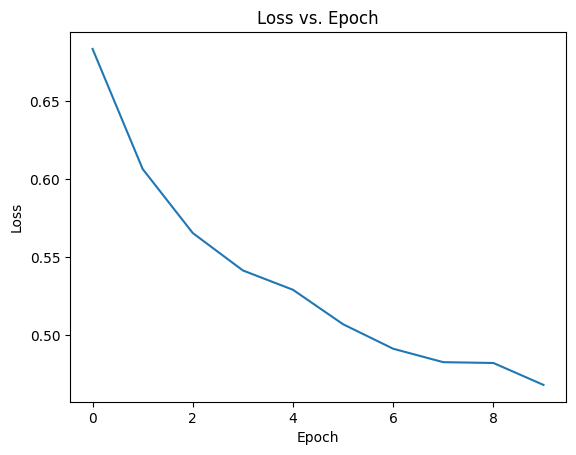

In [7]:
best_hyperparameters, best_accuracy, best_models_loss_record, best_model = hyperparameter_search(train_set, using_mnist=False, spiking_model=True, num_epochs=10, batch_size=32, k=10)
smoothed_loss_record = utils.smooth_k_fold_loss_record(best_models_loss_record)
print(f"Best hyperparameters: {best_hyperparameters}")
print(f"Best accuracy: {best_accuracy}")
plot_loss(smoothed_loss_record)

In [10]:
save_path = f'./model-spiking.pth'
th.save(best_model.state_dict(), save_path)

In [3]:
spiking_cnn = SpikingCNNSerial(beta=0.8, num_steps=10, using_mnist=USING_MNIST)
spiking_cnn = spiking_cnn.to(device)
optimizer = th.optim.Adam(spiking_cnn.parameters(), lr=0.001, weight_decay=0.0001)
training_losses, training_accuracies, testing_losses, testing_accuracies = train_and_test(spiking_cnn, optimizer, train_set, 
                                                                                             test_set, num_epochs=25, batch_size=32, verbose=True)

Epoch 1 loss: 0.67, accuracy: 52.96%
Epoch 1 test loss: 0.56, accuracy: 73.91%
Epoch 2 loss: 0.58, accuracy: 77.15%
Epoch 2 test loss: 0.47, accuracy: 82.61%
Epoch 3 loss: 0.55, accuracy: 76.61%
Epoch 3 test loss: 0.49, accuracy: 86.96%
Epoch 4 loss: 0.53, accuracy: 78.76%
Epoch 4 test loss: 0.47, accuracy: 86.96%
Epoch 5 loss: 0.50, accuracy: 82.80%
Epoch 5 test loss: 0.47, accuracy: 86.96%
Epoch 6 loss: 0.50, accuracy: 83.60%
Epoch 6 test loss: 0.47, accuracy: 86.96%
Epoch 7 loss: 0.48, accuracy: 84.68%
Epoch 7 test loss: 0.46, accuracy: 86.96%
Epoch 8 loss: 0.48, accuracy: 84.68%
Epoch 8 test loss: 0.46, accuracy: 86.96%
Epoch 9 loss: 0.47, accuracy: 86.56%
Epoch 9 test loss: 0.46, accuracy: 86.96%
Epoch 10 loss: 0.47, accuracy: 86.29%
Epoch 10 test loss: 0.46, accuracy: 86.96%
Epoch 11 loss: 0.47, accuracy: 86.29%
Epoch 11 test loss: 0.45, accuracy: 86.96%
Epoch 12 loss: 0.46, accuracy: 87.63%
Epoch 12 test loss: 0.46, accuracy: 86.96%
Epoch 13 loss: 0.46, accuracy: 87.10%
Epoch 13

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/syntactic/miniconda3/envs/ModelingSynapticPlasticity/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(

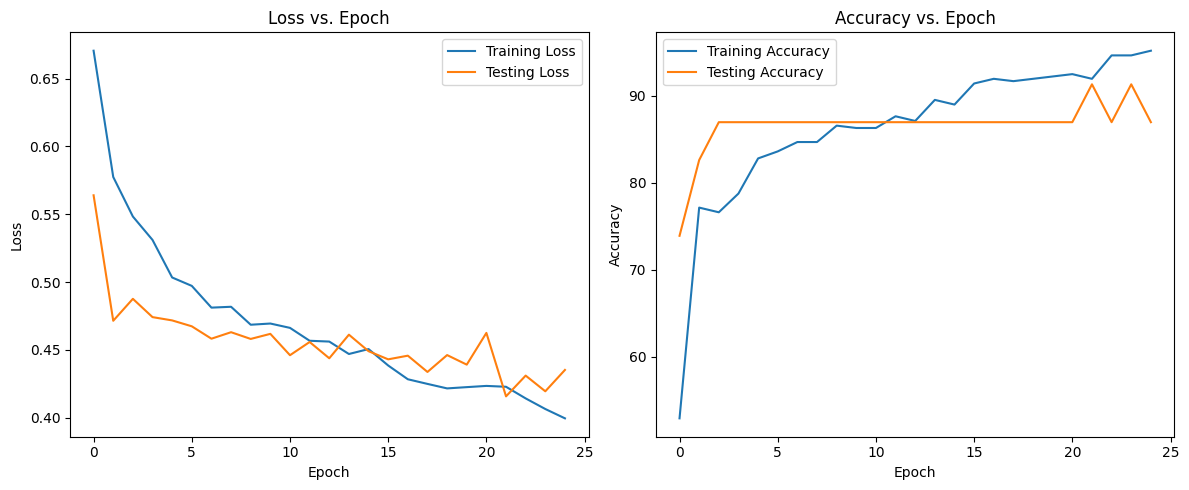

In [4]:
from plotting import plot_training_testing_metrics
plot_training_testing_metrics(training_losses, training_accuracies, testing_losses, testing_accuracies)

In [5]:
fpr, tpr, thresholds, auc_scores = get_roc_metrics(spiking_cnn, test_set, batch_size=32)

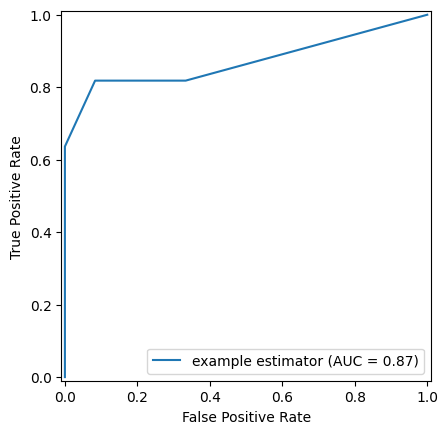

In [7]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_scores,

                                  estimator_name='example estimator')

display.plot()